# Real-Time Face Mask Detection Project 

Inspired by the rise of COVID-19, this is a mini project which detects whether a user is wearing a mask or not.


It utilises TensorFlow, Keras and OpenCV, to implement real-time camera detection capabilties!

In [1]:
# Importing libraries and modules

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt

import numpy as np
import os
import cv2

### Sampling the Dataset

In [2]:
# Sample with mask image
img_sample = cv2.imread("faces_dataset/with_mask/with_mask_3.jpg")

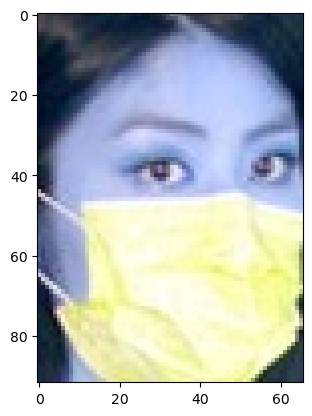

In [3]:
# image sample with mask
plt.imshow(img_sample)

In [4]:
# sample without mask image
img_sample2 = cv2.imread("faces_dataset/without_mask/without_mask_5.jpg")

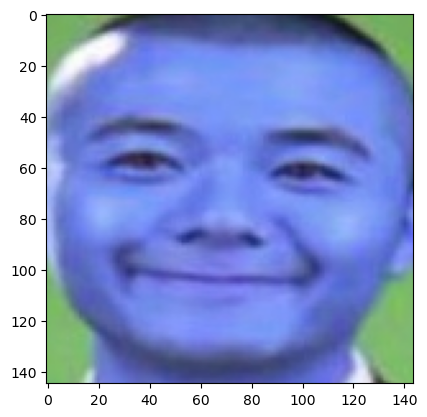

In [5]:
plt.imshow(img_sample2)

## Data Cleaning & Processing

In [6]:
# Path to dataset directory
dataset_path = 'faces_dataset/'

# Categories
categories = ['with_mask', 'without_mask']

img_data = [] # list to store image data, after being loaded and preprocessed
labels = [] # list to store corresponding labels for each image in the dataset (either with_mask or without_mask)

# Loading images, store in img_data and labels
for category in categories:
    path = os.path.join(dataset_path, category) #combines dataseth path w category to get full path
    
    for img_name in os.listdir(path): # iterates over all img filenames 
        img_path = os.path.join(path, img_name) # constructs full path to each img
        img = load_img(img_path, target_size=(224, 224)) # RESIZES img to 224,224 pixels
        img = img_to_array(img) # converts img to numpy array for model training later
        img = preprocess_input(img) # preprocesses the img using MobileNetV2's preprocessing function (normalizes pixel values).
        
        # Appending data
        img_data.append(img)
        labels.append(category) # adds the category label
        
    


C:\Users\kejun\anaconda3\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# saving preprocessed data
# np.save("img_data.npy", img_data)
# np.save("labels.npy", labels)

In [7]:
# Number of images with mask
data_with_mask_dir = '/Users/kejun/Personal Projects/Face_Mask_Detection/faces_dataset/with_mask'
data_without_mask_dir = '/Users/kejun/Personal Projects/Face_Mask_Detection/faces_dataset/without_mask'

data_with_mask = os.listdir(data_with_mask_dir)
data_without_mask = os.listdir(data_without_mask_dir)


print('Number of images with mask: ', len(data_with_mask))
print('Number of images without mask: ', len(data_without_mask))

Number of images with mask:  3725
Number of images without mask:  3828


## Preparation to train the model

- Learning Rate:
The initial learning rate (INIT_LR) is a hyperparameter used in training machine learning models, particularly in gradient-based optimization algorithms like stochastic gradient descent (SGD) or Adam. The value controls how quickly the model learns during training.

- Epochs:
An epoch in machine learning represents one full pass of the entire training dataset through the model during training. The training process typically involves multiple epochs to allow the model to learn effectively. Training over multiple epochs helps the model improve its accuracy by learning from the data repeatedly and adjusting the weights iteratively.

- Batch Size (BS):
 The batch size is the number of training samples processed in one iteration before the model's weights are updated. This means the model will process 32 images at a time before performing a weight update, in my code.

In [ ]:
# loading preprocessed data
# img_data = np.load("img_data.npy")
# labels = np.load("labels.npy")

In [8]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer() # converts categorical labels into BINARY format, 'with_mask' → [0] and 'without_mask' → [1].
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Converting data to numpy arrays
img_data = np.array(img_data, dtype="float32")
labels = np.array(labels)

# Splitting data into Training & Test Sets (80 20)
(trainX, testX, trainY, testY) = train_test_split(img_data, labels,
    test_size=0.20, stratify=labels, random_state=42)

#### Data Augmentation

Data Augmentation is used to artificially expand the training dataset by applying transformations randomly.

In [10]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3))) # Sets the input size to 224x224 pixels with 3 color channels (RGB).


# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

C:\Users\kejun\AppData\Local\Temp\ipykernel_32512\123186660.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


#### Freezing Base Model's Layers

The base MobileNetV2 model is pre-trained on ImageNet. By freezing these layers, you prevent them from being updated during the initial training phase.
This allows the custom head (the newly added layers) to be trained first while retaining the base model's pre-trained features.

In [11]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model, using Adam, an adaptive optimisation algorithm
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


C:\Users\kejun\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### Training the Model

In [12]:
# train the head of the network
print("[INFO] training model...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] training model...
Epoch 1/10


C:\Users\kejun\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 148s 735ms/step - accuracy: 0.8052 - loss: 0.4795 - val_accuracy: 0.9768 - val_loss: 0.0916
Epoch 2/10


C:\Users\kejun\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9375 - loss: 0.2082 - val_accuracy: 0.9762 - val_loss: 0.0912
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 113s 589ms/step - accuracy: 0.9692 - loss: 0.1119 - val_accuracy: 0.9808 - val_loss: 0.0575
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9688 - loss: 0.1338 - val_accuracy: 0.9808 - val_loss: 0.0574
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 123s 647ms/step - accuracy: 0.9787 - loss: 0.0735 - val_accuracy: 0.9841 - val_loss: 0.0485
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 1.0000 - loss: 0.0307 - val_accuracy: 0.9841 - val_loss: 0.0484
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 120s 613ms/step - accuracy: 0.9849 - loss: 0.0543 - val_accuracy: 0.9861 - val_loss: 0.0432
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 1.0000 - loss: 0.0406 - val_accuracy: 0.9874 - val_loss: 0.0433
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 114s 594ms/step - accuracy: 0.9856 - loss: 0.0478 - val

Loss Calculation: The difference between predictions and actual labels is calculated using the loss function.

Validation: After each epoch, the model is evaluated on the validation data to monitor overfitting.

In [13]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 355ms/step


The model above looks at each image in the test set (testX) and tries to guess if the image shows someone "with a mask" or "without a mask."

The output (predIdxs) is a list of probabilities for each image.

In [14]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.98      0.98       745
without_mask       0.98      0.99      0.98       766

    accuracy                           0.98      1511
   macro avg       0.98      0.98      0.98      1511
weighted avg       0.98      0.98      0.98      1511



##### Metrics Explained:
Precision:
Measures how many of the predicted positives were actually correct.

Recall (Sensitivity):
Measures how many of the actual positives were correctly identified.

F1-Score:
The harmonic mean of precision and recall.

Support:
The number of true instances for each class in the test dataset.

Accuracy:
Overall proportion of correctly classified samples.

##### Overall Results:

Accuracy: 98% of all predictions were correct.

Macro Avg: Average of precision, recall, and F1-score across both classes (useful for balanced evaluation).

Weighted Avg: Like macro average but weighted by the number of samples in each class (important if one class has more data).

In [15]:
# saving model into file
print("[INFO] saving mask detector model...")
model.save("mask_detector2.keras")

[INFO] saving mask detector model...


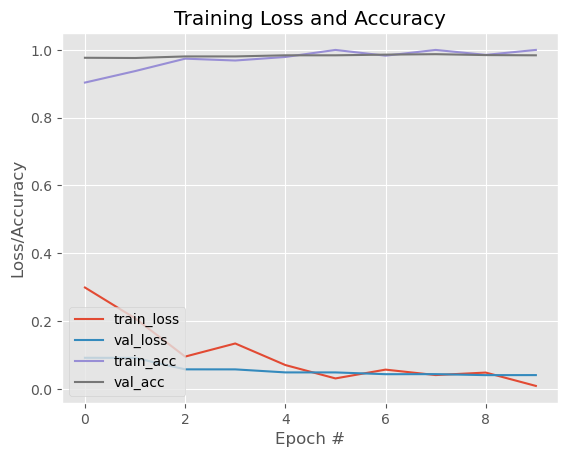

In [16]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Real-Time Webcam Detection

In [17]:
# Importing libraries & modules
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream

import time
import imutils

In [31]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)


In [32]:
# load our serialized face detector model from disk
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model("mask_detector2.keras")

In [33]:
# initialize the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

[INFO] starting video stream...


In [34]:
# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(1, 1, 2